# Predicting Flight Ticket Prices for JetBlue in New York

**Notebook Authors**:
- Chris Kuzemka
- Irene Chau
- Ali Nazim
- Yurica Xu
- Aqib Rahim

##  Imports & Notebook Functions

In [18]:
import os
import pandas as pd
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

In [19]:
def table_datetime_conversion(df):
    # Convert 'searchDate' and 'flightDate' to datetime, handling potential errors
    df['searchDate'] = pd.to_datetime(df['searchDate'], format='%Y-%m-%d', errors='coerce')
    df['flightDate'] = pd.to_datetime(df['flightDate'], format='%Y-%m-%d', errors='coerce')

    # Ensure the columns are of datetime type
    df['searchDate'] = df['searchDate'].astype('datetime64[ns]')
    df['flightDate'] = df['flightDate'].astype('datetime64[ns]')

    return df

## Data Builder

In [ ]:
base_df = pd.read_csv("../data/cleaned_jetblue_df.csv") #cleaned

jetblue_df = pd.read_csv("../data/jetblue_df.csv")
model_encoding_df = pd.read_csv("../data/model_encoded_jetblue_df.csv")

base_df = table_datetime_conversion(base_df)
jetblue_df = table_datetime_conversion(jetblue_df)


FileNotFoundError: [Errno 2] No such file or directory: '../model_encoded_jetblue_df.csv'

# Table of Contents

Here goes the sections of this notebook breakdown and we can apply relevant authors to it as well. 

## Data Overview

**Yurica Xu**

| Variable Name | Expected Data Type | Description |
|--------------|-------------------|-------------|
| searchDate | datetime | Date when the flight search was performed |
| searchDayOfWeek | int/string | Day of the week when search was performed |
| route | string | Flight route code |
| flightDate | datetime | Scheduled date of the flight |
| flightDayOfWeek | int/string | Day of the week of the flight |
| startingAirport | string | Departure airport code |
| destinationAirport | string | Arrival airport code |
| elapsedDays | int | Number of days between search date and flight date |
| isBasicEconomy | boolean | Whether the ticket is basic economy class |
| isRefundable | boolean | Whether the ticket is refundable |
| isNonStop | boolean | Whether the flight is non-stop |
| baseFare | float | Base ticket price before taxes and fees |
| totalFare | float | Total price including all taxes and fees |
| seatsRemaining | int | Number of seats available |
| totalTravelDistance | float | Total flight distance |
| segmentsDepartureTimeRaw | datetime | Raw departure time for flight segments |
| segmentsArrivalTimeRaw | datetime | Raw arrival time for flight segments |
| segmentsArrivalAirportCode | string | Airport code for segment arrival |
| segmentsDepartureAirportCode | string | Airport code for segment departure |
| segmentsAirlineName | string | Name of the airline |
| segmentsDurationInSeconds | int | Duration of flight segments in seconds |
| segmentsCabinCode | string | Cabin class code |
| departureTime | datetime | Flight departure time |
| arrivalTime | datetime | Flight arrival time |
| departureCategory | string | Category of departure time (e.g., morning/afternoon) |
| arrivalCategory | string | Category of arrival time (e.g., morning/afternoon) |
| isHolidaySearchDate | boolean | Whether the search date is a holiday |
| isHolidayFlightDate | boolean | Whether the flight date is a holiday |
| nearHolidaySearchDate | boolean | Whether the search date is near a holiday |
| nearHolidayFlightDate | boolean | Whether the flight date is near a holiday |
| searchDateInt | int | Integer representation of search date |
| flightDateInt | int | Integer representation of flight date |
| daysLeft | int | Days remaining until flight departure |
| numStops | int | Number of stops in the flight route |


Above is the data dicitonary of our cleaned JetBlue dataframe. This existence of this data dictionary is often considered good practice when making a data science study. It helps the project group and readers know exactly what exists in our data. This will also help new collaborators kickstart their work much quicker. 

Columns that were added to our dataset via feature engineering include:
- seachDayOfWeek
- route
- flightDayOfWeek
- departureCategory
- arrivalCategory
- isHolidaySearchDate
- isHolidayFlighthDate
- nearHolidaySearchDate
- nearHolidayFlightDate
- searchDateInt
- flighthDateInt
- daysLeft
- numStops

#  Data Exploration and Cleaning

## Reading Kaggle Itineraries 

### Christopher Kuzemka

The original project began with observing a 30GB dataset from Kaggle. For the sake of conserving space, the processing notebook used to explore this master is no longer available as the dataset was largely discarded in favor of computational efficiency. For the purpose of this section, we still will briefly discuss the content of Kaggle's itineraries dataset and will be referencing the [project's data source](https://www.kaggle.com/datasets/dilwong/flightprices). The source itself labels that there are only 5.9M columns, but our group had to strongly reduce the size of the dataset. Practically speaking, we als sport a final dataframe of approximately 3.9M rows with a file size approximately 1GB. The math just doesn't add up and we believe Kaggle (or the author) made an error here. 

Regardless, the 30GB original dataframe sporadically included information from a variety of airlines. Our quick-attempt to find the best dataset was to choose a subsection filter off of the itineraries dataframe. The choices between difference dataframes came down to 3 proposed airlines:

- AmericanAirlines (~10-12GB)
- Delta (~4GB)
- JetBlue (~1GB)

Note that the files sizes shown above are approximatiions as the originals were later deleted and the notebook affiliated with such also removed. 

In the next section we talk about the chosen dataframe. 

In [15]:
print(f"The shape of our cleaned JetBlue df is: {base_df.shape}")

print(f"The shape of our uncleaned JetBlue df is: {jetblue_df.shape}")

print(f"The size of our cleaned JetBlue df is: {base_df.size}")

print(f"The size of our uncleaned JetBlue df is: {jetblue_df.size}")

The shape of our cleaned JetBlue df is: (3929953, 34)
The shape of our uncleaned JetBlue df is: (6824440, 28)
The size of our cleaned JetBlue df is: 133618402
The size of our uncleaned JetBlue df is: 191084320


## JetBlue Focus

### Christopher Kuzemka**

JetBlue was the winning dataframe for a small number of reasons. The first was that the dataset was small to process but rich in size for our project (against housing approximately 3.9M rows). We organized our cleaning processes through a cleaning script found in our project's `toolkit` folder. The cleaning script accepted this approximate 2GB dataset of uncleaned JetBlue data and converted it into the cleaned JetBlue data we have today.

The uncleaned data is represented as the variable `jetblue_df` and the cleaned data is represented as the variable `base_df` (the naming convention here to signify a working dataframe).

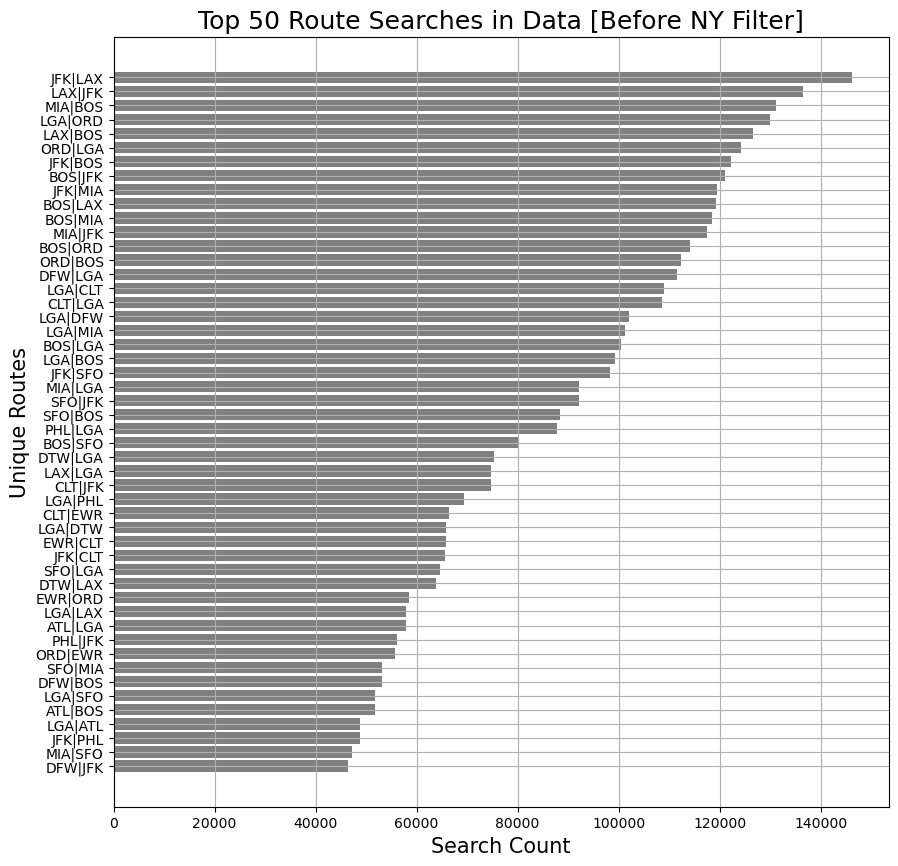

In [ ]:
plot_df = jetblue_df.copy()

plot_df['route']=plot_df['startingAirport'] + '|' + plot_df['destinationAirport']

search_counts = (
    plot_df
    .groupby(
        "route"
    )["searchDate"]
    .agg(
        "count"
    )
)

search_counts = search_counts.sort_values(ascending=False)
search_counts = pd.DataFrame(search_counts)

top_50_routes_of_jetblue = search_counts.head(50)

plt.figure(figsize=(10,10))

plt.gca().invert_yaxis()
plt.barh(top_50_routes_of_jetblue.index, top_50_routes_of_jetblue["searchDate"], color="gray")

plt.title("Top 50 Route Searches in Data [Before NY Filter]", size=18)
plt.ylabel("Unique Routes", size=15)
plt.xlabel("Search Count", size=15)
plt.grid(which="major")

**NY Model Introduction**

When considering our goal of making a predictive pricing model, it became more apparant that a variety of airports would bias the model severely and different markets may suffer due to these assumed biases. The suggestion of further reducing our scope to isolate on a specific market in the US was to consider a single market to focus on. The term "New York model" became attractive due to the high presence of JFK and LGA. We included EWR (Newark, NJ) into our consideration of a New York filter due to it being a popular airport for people who travel in and out of NYC. 

This filter reduced our dataframe significantly down to approximately 3.9M rows. 

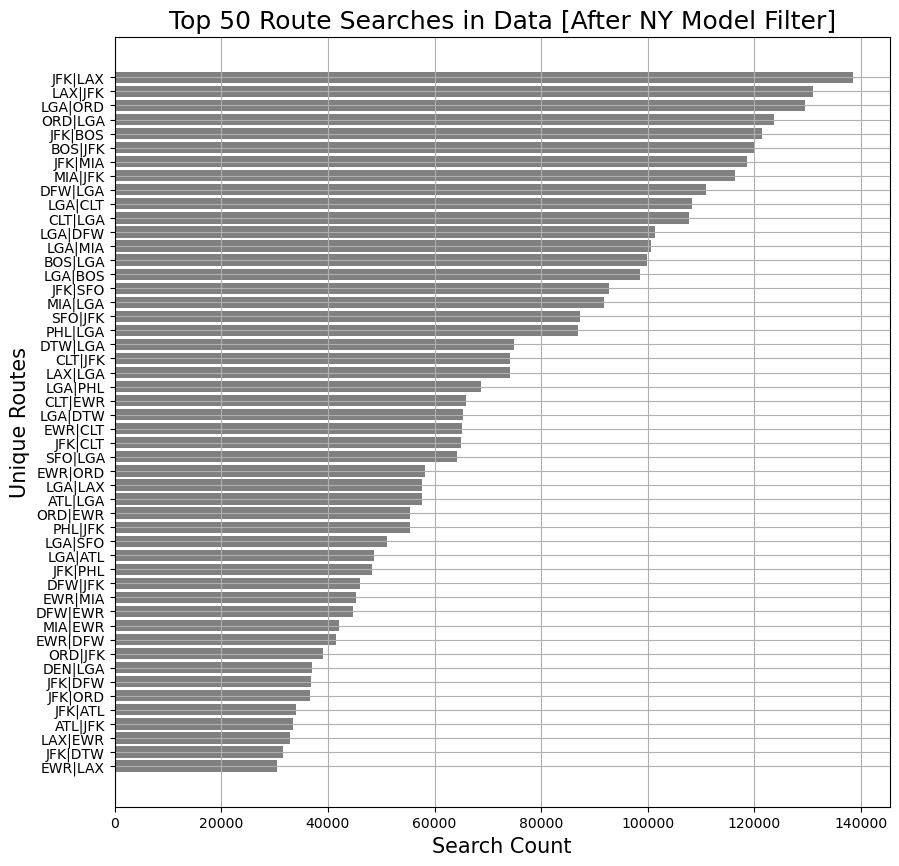

In [62]:
plot_df = base_df.copy()

plot_df['route']=plot_df['startingAirport'] + '|' + plot_df['destinationAirport']

search_counts = (
    plot_df
    .groupby(
        "route"
    )["searchDate"]
    .agg(
        "count"
    )
)

search_counts = search_counts.sort_values(ascending=False)
search_counts = pd.DataFrame(search_counts)

top_50_routes_of_jetblue = search_counts.head(50)

plt.figure(figsize=(10,10))

plt.gca().invert_yaxis()
plt.barh(top_50_routes_of_jetblue.index, top_50_routes_of_jetblue["searchDate"], color="gray")

plt.title("Top 50 Route Searches in Data [After NY Filter]", size=18)
plt.ylabel("Unique Routes", size=15)
plt.xlabel("Search Count", size=15)
plt.grid(which="major")

We will note that the numbers in magnitude for specific routes do not directly match up to the plot above. This is a byproduct of further cleaning that was implemented into the master and later addressed. All is tracked via the `jetblue_cleaning_script.py` in the `toolkit` folder. The `route` column was also included into the cleaned dataframe which was provided by **Irene Chau**.

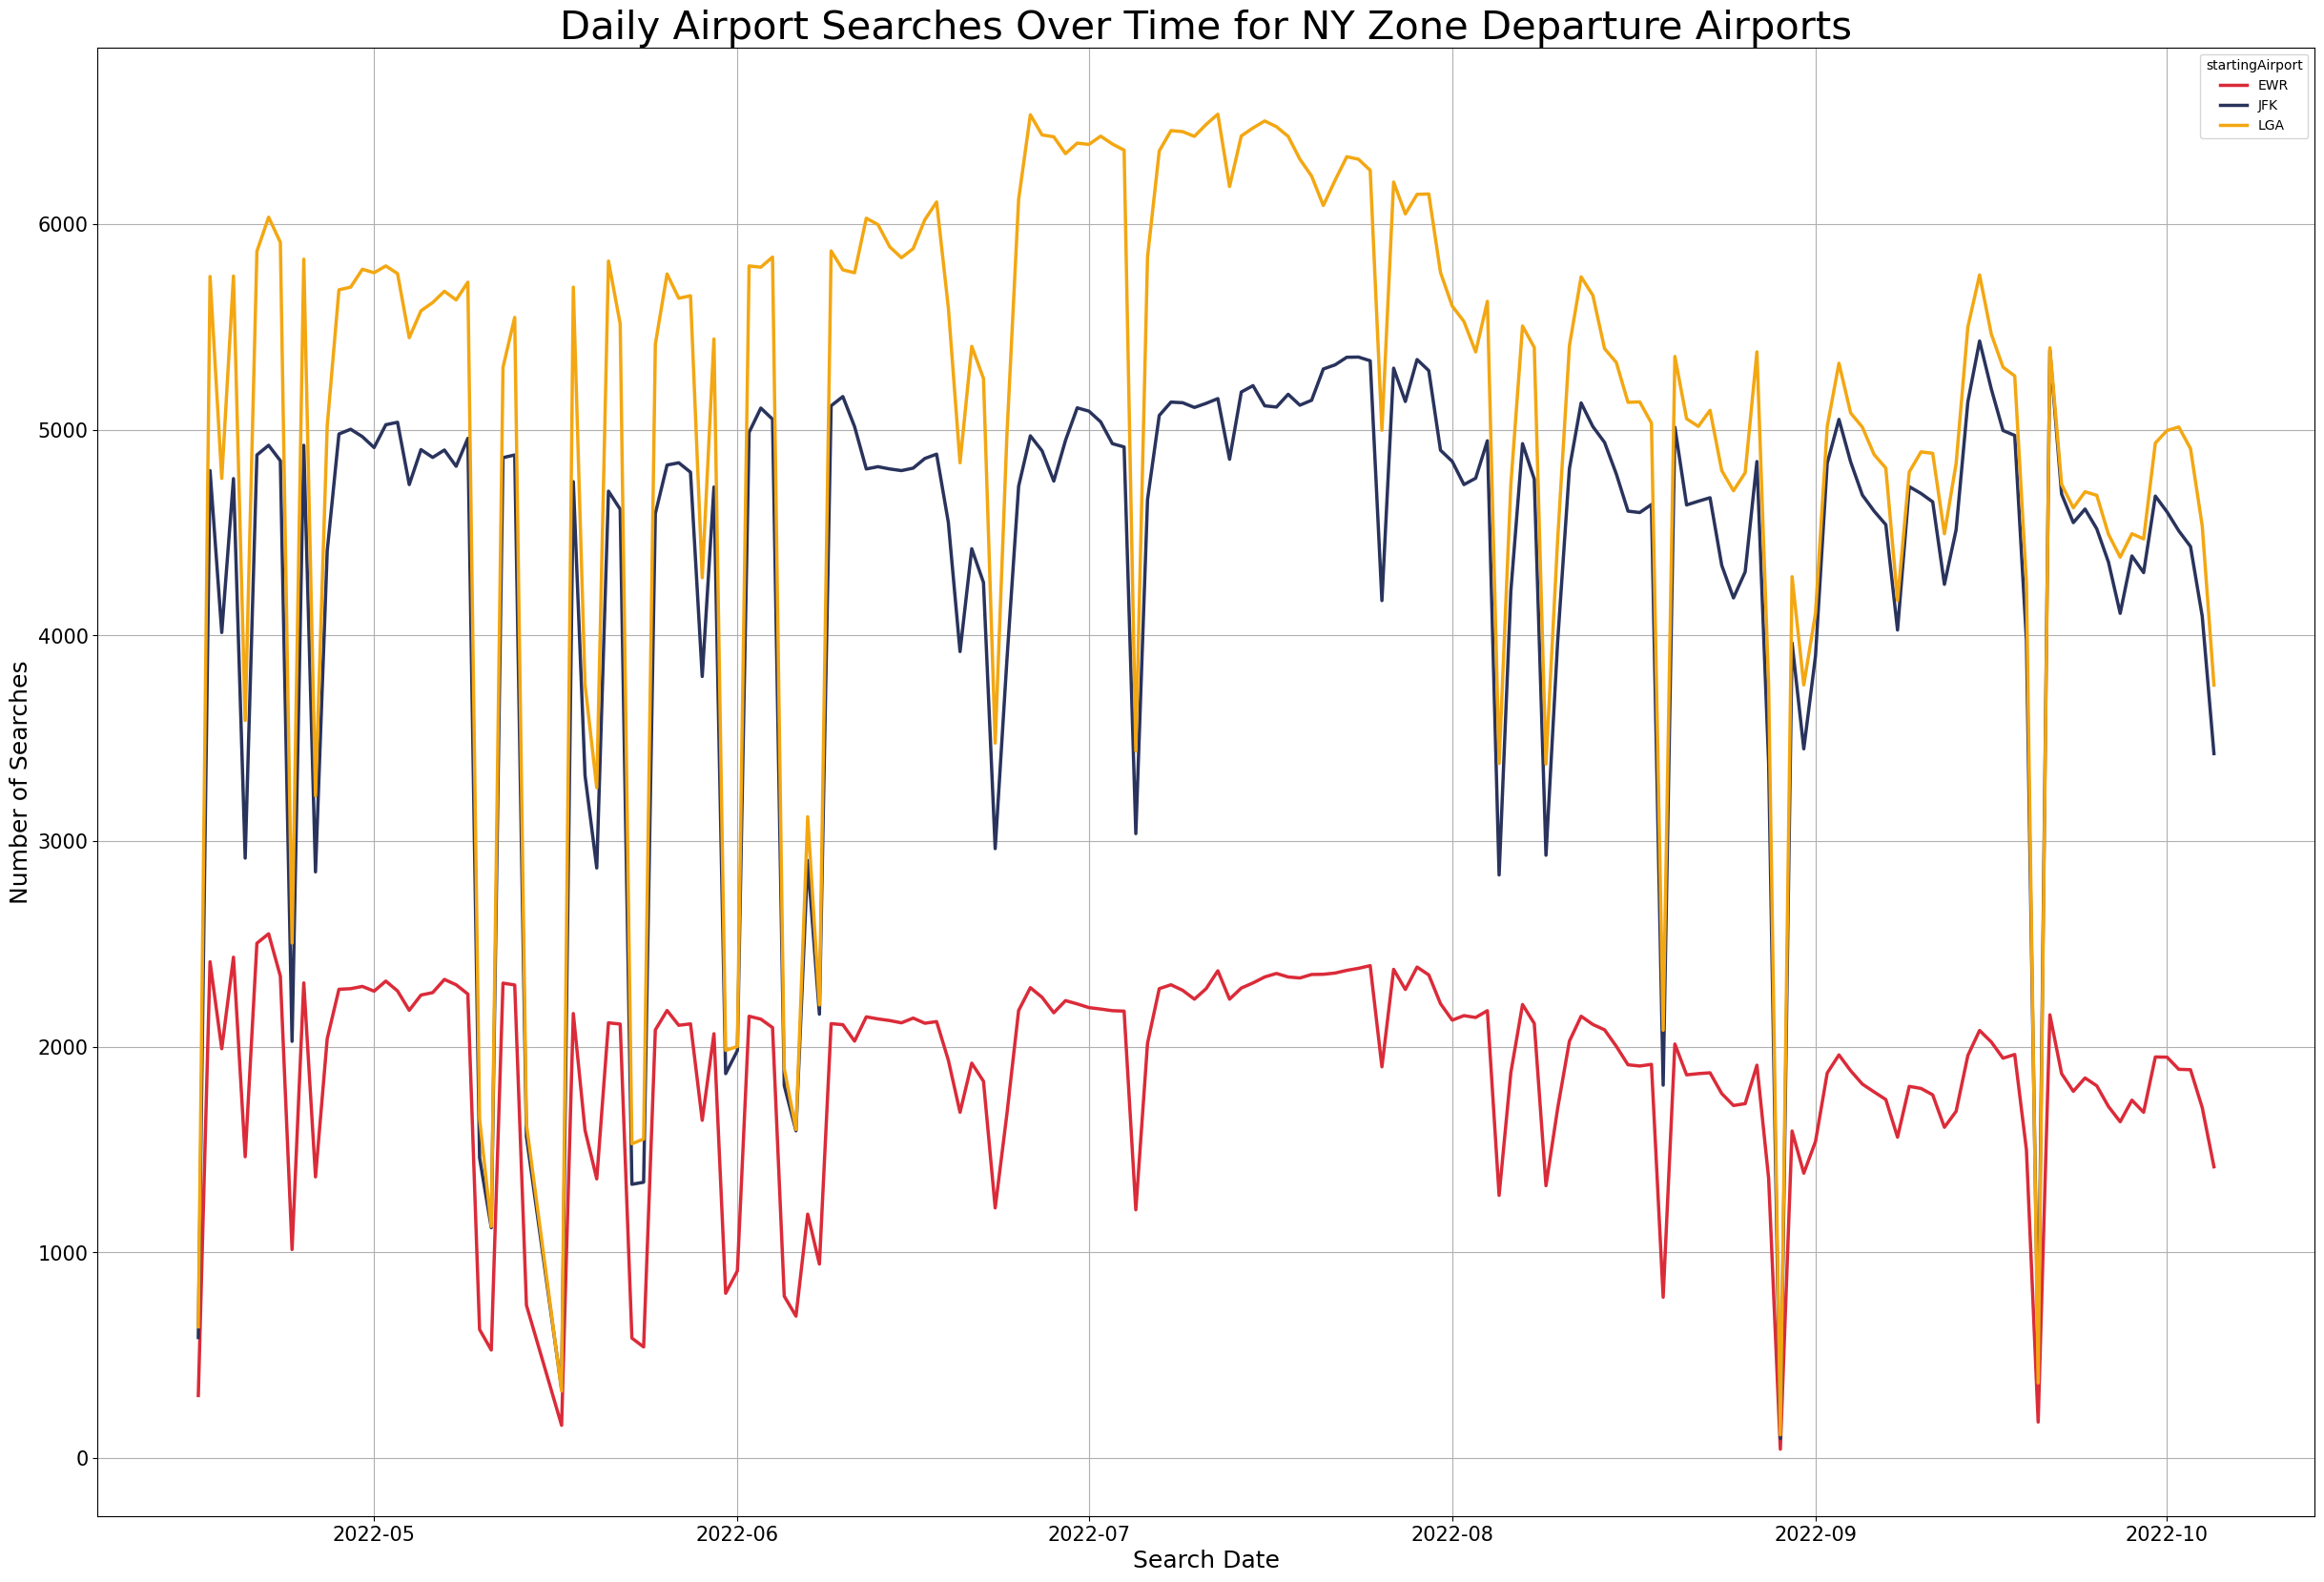

In [ ]:
plot_df = base_df.copy()
airport_colors = ["#db2b39", "#29335c", "#f3a712"]
departure_filter = ["LGA", "JFK", "EWR"]

plot_df = (
    plot_df[
        plot_df["startingAirport"].isin(departure_filter)
    ]
    .groupby(
        ["searchDate", "startingAirport"], dropna=False
    )
    .size()
    .reset_index(name="searchCount")
    .sort_values("searchDate", ascending=True)
)

unique_combinations = plot_df["startingAirport"].unique()

full_date_range = pd.date_range(start=plot_df['searchDate'].min(), end=plot_df['searchDate'].max())
full_date_range = pd.date_range(start=plot_df['searchDate'].min(), end=plot_df['searchDate'].max())

complete_index = pd.MultiIndex.from_product([full_date_range, unique_combinations], names=["searchDate", "startingAirport"])
full_data = pd.DataFrame(index=complete_index).reset_index()

merged_data = pd.merge(full_data, plot_df, on=["searchDate", "startingAirport"], how="left") #we do a merge of our global date range with our data based on similar keys

#P#lotting
plt.figure(figsize=(30,20))

sns.lineplot(x=merged_data["searchDate"], y=merged_data["searchCount"], hue=merged_data["startingAirport"], palette=airport_colors, linewidth=2.5)


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel("Search Date", size=18)
plt.ylabel("Number of Searches", size=18)
plt.title("Daily Airport Searches Over Time for NY Zone Departure Airports", size=30)
plt.grid(axis="both")

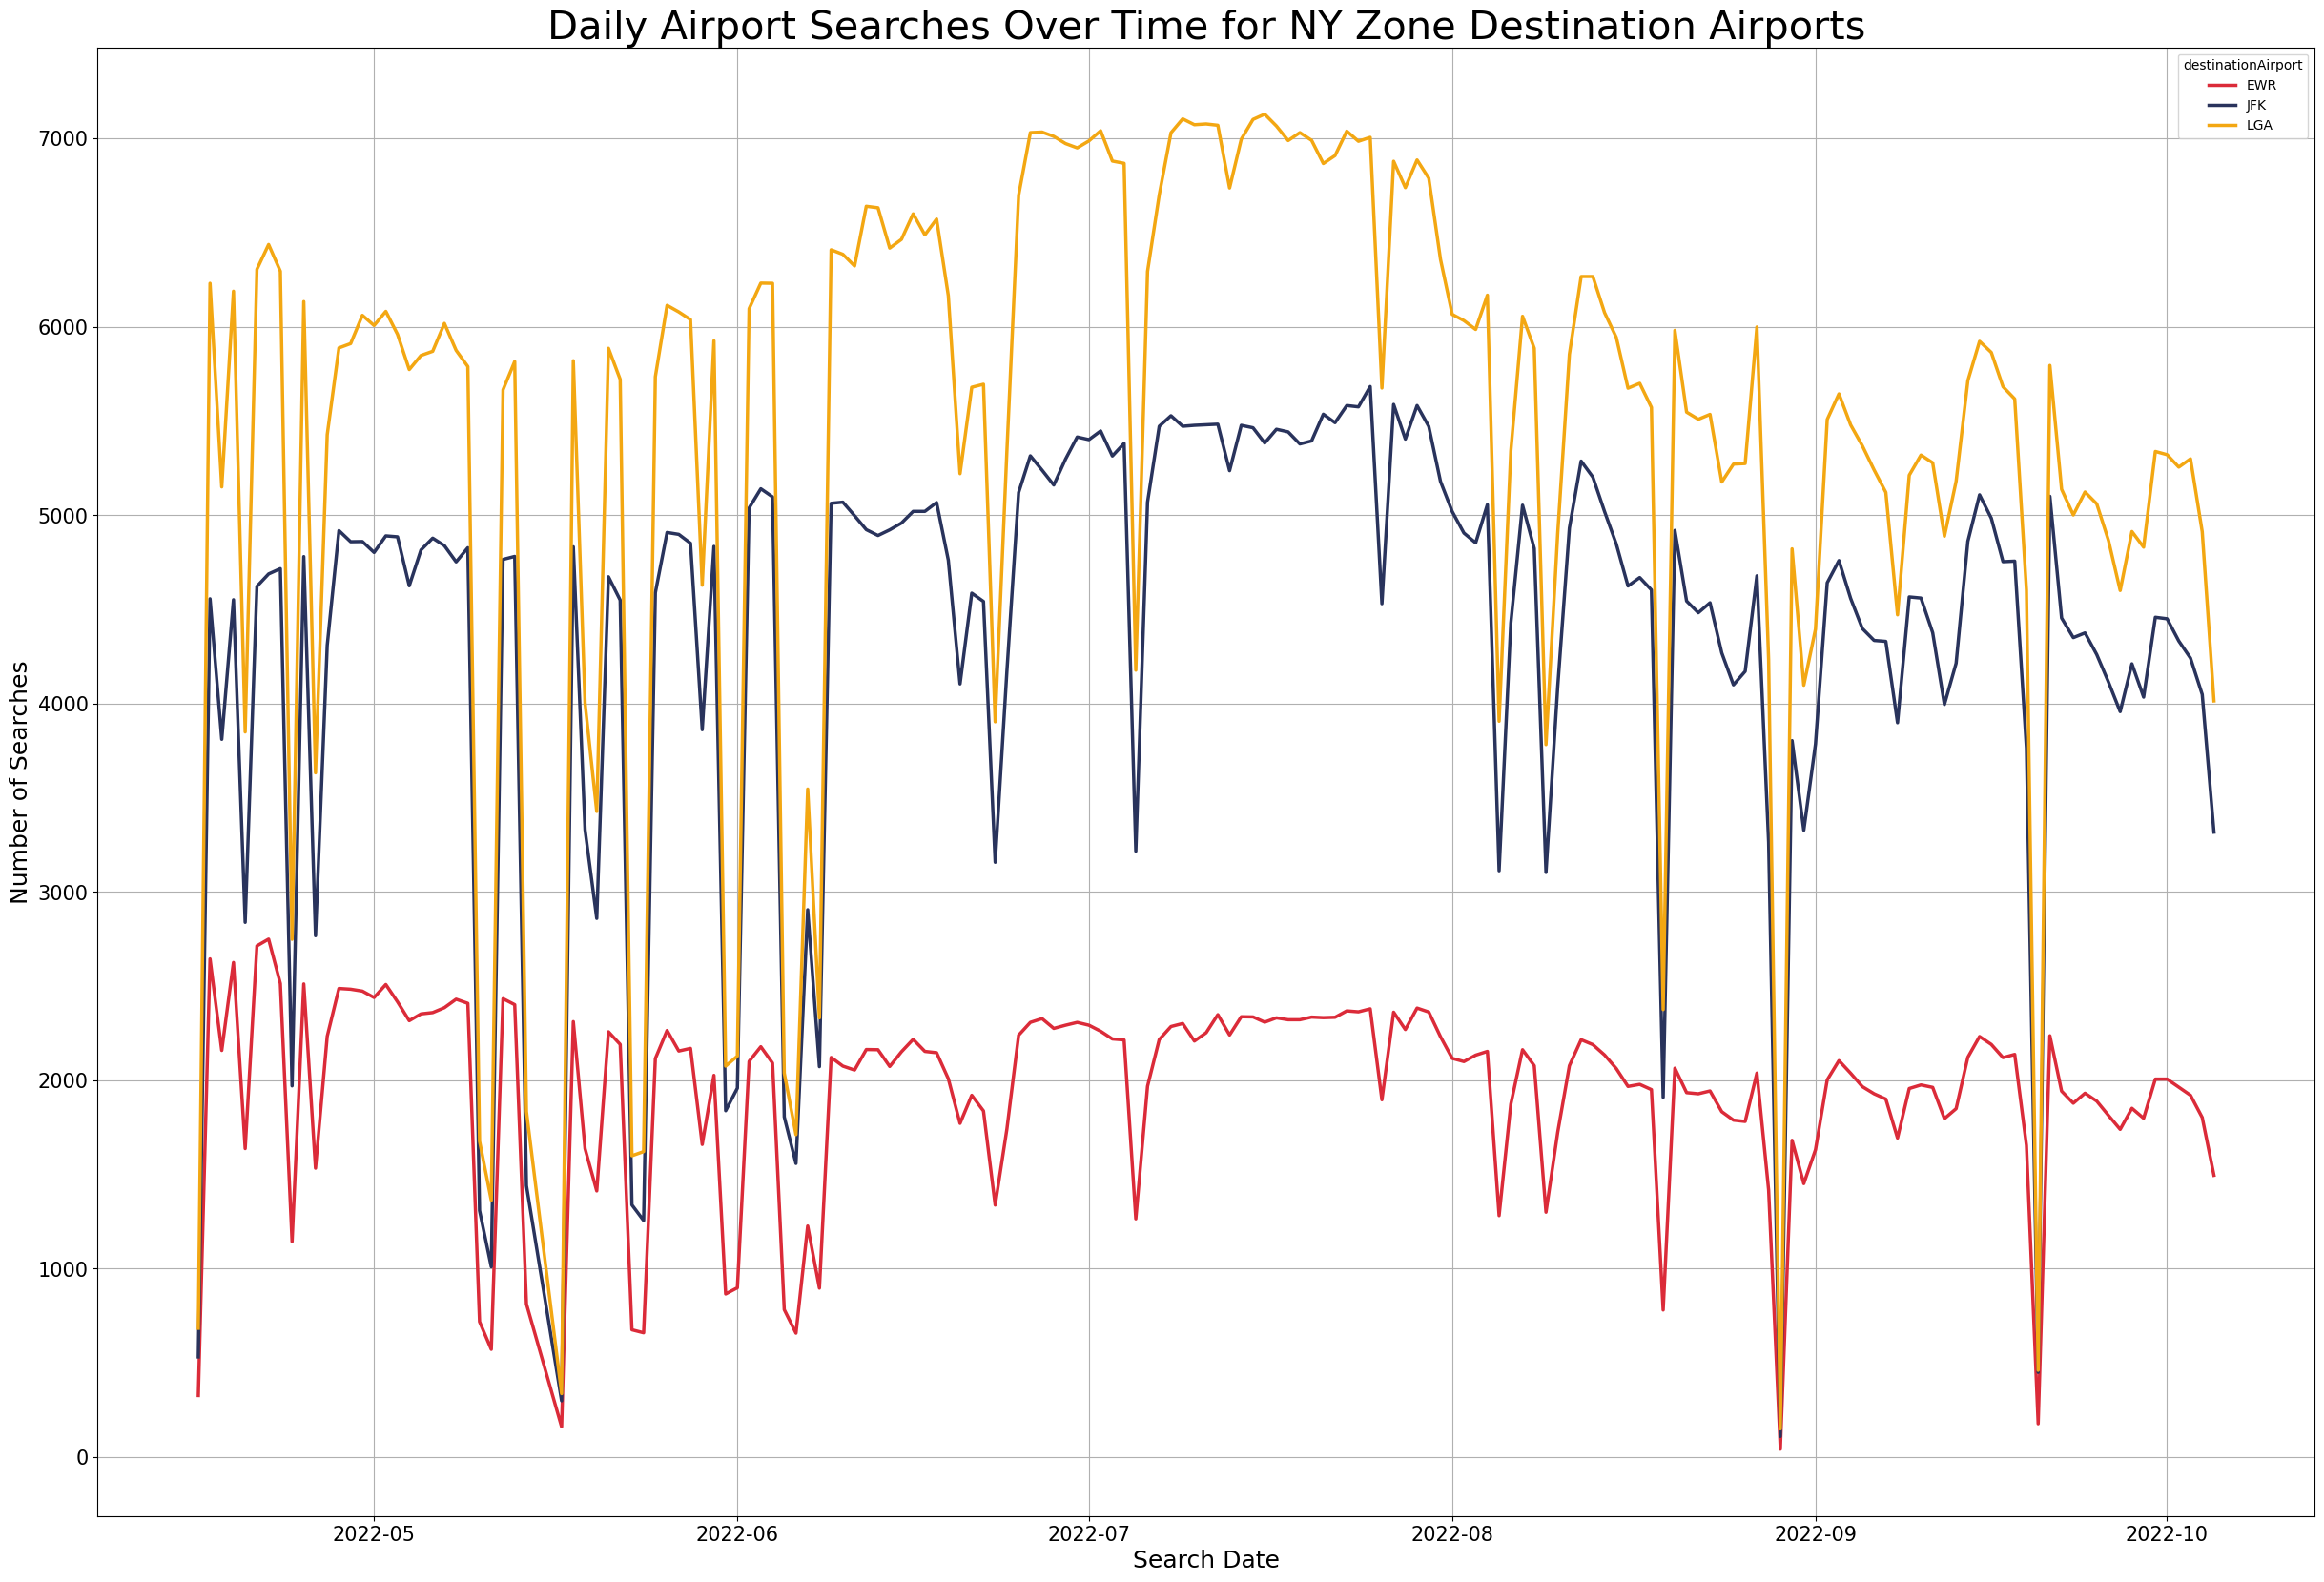

In [14]:
plot_df = base_df.copy()
airport_colors = ["#db2b39", "#29335c", "#f3a712"]
departure_filter = ["LGA", "JFK", "EWR"]

plot_df = (
    plot_df[
        plot_df["destinationAirport"].isin(departure_filter)
    ]
    .groupby(
        ["searchDate", "destinationAirport"], dropna=False
    )
    .size()
    .reset_index(name="searchCount")
    .sort_values("searchDate", ascending=True)
)

unique_combinations = plot_df["destinationAirport"].unique()

full_date_range = pd.date_range(start=plot_df['searchDate'].min(), end=plot_df['searchDate'].max())
full_date_range = pd.date_range(start=plot_df['searchDate'].min(), end=plot_df['searchDate'].max())

complete_index = pd.MultiIndex.from_product([full_date_range, unique_combinations], names=["searchDate", "destinationAirport"])
full_data = pd.DataFrame(index=complete_index).reset_index()

merged_data = pd.merge(full_data, plot_df, on=["searchDate", "destinationAirport"], how="left") #we do a merge of our global date range with our data based on similar keys

#P#lotting
plt.figure(figsize=(30,20))

sns.lineplot(x=merged_data["searchDate"], y=merged_data["searchCount"], hue=merged_data["destinationAirport"], palette=airport_colors, linewidth=2.5)


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel("Search Date", size=18)
plt.ylabel("Number of Searches", size=18)
plt.title("Daily Airport Searches Over Time for NY Zone Destination Airports", size=30)
plt.grid(axis="both")

More people fly into these airports than fly out when comparing the magnitude changes. However there are times where `searchDate` "groupings appear. 

## Cleaning

**Christopher Kuzemka**, **Irene Chau**(?)


(little nuances) <- nulls, useless features, 

- nulls 

(problems with labeling and constraints) <- made up information or missing information or inconsistent labeling lacking data

(outliers and why they are outliers)



As the file was mostly processed as a `.csv` whenever loaded in, we lost the capability of sustaining datetime objects and therefore re-converted our date related columns into datetime objects for stronger Python processing. Even though we are processing in a cleaned dataframe, we will again redo this process. In the future, we will consider saving this dataframe as either a `parquet` or `pickle` file format which will sustain unique object types upon saving. For simple data storage, we stuck with `.csv` files. 

In [65]:
##Everyone did this
base_df = table_datetime_conversion(base_df)
jetblue_df = table_datetime_conversion(jetblue_df)

## Feature Engineering and KPIs

(showoff some of the features created and plotting)

# Model Preprocessing

(re-discussion of any points on how the model might be influenced based on what we know)

(model encoding strategeis)



## Encoding

### Christopher Kuzemka

I'm gonna cover one-hot and go over my modeling script...talk about day of week stuff as well. 

# Modeling

(preliminary models)

(discussion of observations and failures)

(showing off different models)

(discussion and nshowcasing of best models)

# Model Application

(discuss how the model is used in an applicable setting)

(consider discussions on how it can be improved)

(discuss how the scope could be increased to other airports and routes or markets if applicable)

# merging

hopefully this works